# Init things

In [1]:
import numpy as np
from astropy.io import fits
import numpy as np
import astropy.units as u
import astropy.constants as const

import pprint
import logging
import os

import matplotlib
import matplotlib.pyplot as plt
%pylab inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 15

import scipy.ndimage.interpolation
import scipy.signal
import skimage.transform


cmap='inferno'

Populating the interactive namespace from numpy and matplotlib


# Test wavelength interpolation

In [2]:
spc_psf_path = '/Users/mrizzo/IFS/OS6/SPC/spc_os6/'
psf_series_fname = spc_psf_path+'os6_spc_770nm_muf_images.fits'

In [3]:
psf_series = fits.open(psf_series_fname)[0].data[0]

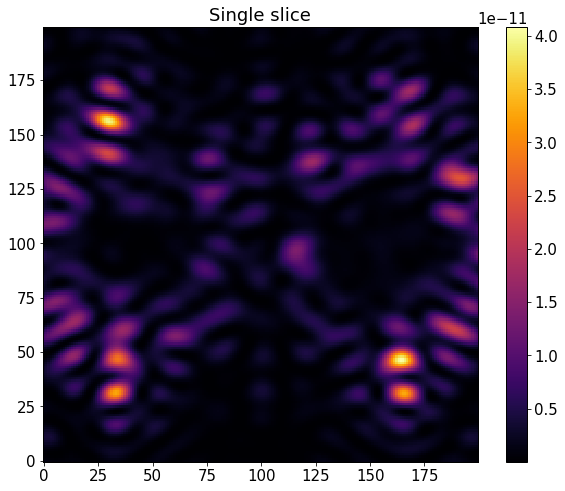

In [4]:
plt.figure(figsize=(10,8))
plt.imshow(psf_series[0],cmap=cmap)
plt.title('Single slice')
plt.colorbar()

In [5]:
wavel = np.linspace(0.7,0.84,11)
print wavel

[ 0.7    0.714  0.728  0.742  0.756  0.77   0.784  0.798  0.812  0.826
  0.84 ]


## Spline interpolate

In [6]:
import scipy.ndimage as ndimage
data_filtered = ndimage.spline_filter(psf_series,order=3)


## Create maps

In [7]:
nl,nx,ny = psf_series.shape
x = np.arange(nx)
y = np.arange(ny)
new_wavel = np.linspace(0.7,0.84,25)
l = (new_wavel-0.7)*(nl-1)/(0.84-0.7)
print l
print new_wavel
l,x,y = np.meshgrid(l,x,y)
newpsf = ndimage.map_coordinates(data_filtered,[l,x,y],prefilter=True,mode='nearest')
newpsf = np.swapaxes(newpsf,0,1)

[  0.           0.41666667   0.83333333   1.25         1.66666667
   2.08333333   2.5          2.91666667   3.33333333   3.75         4.16666667
   4.58333333   5.           5.41666667   5.83333333   6.25         6.66666667
   7.08333333   7.5          7.91666667   8.33333333   8.75         9.16666667
   9.58333333  10.        ]
[ 0.7         0.70583333  0.71166667  0.7175      0.72333333  0.72916667
  0.735       0.74083333  0.74666667  0.7525      0.75833333  0.76416667
  0.77        0.77583333  0.78166667  0.7875      0.79333333  0.79916667
  0.805       0.81083333  0.81666667  0.8225      0.82833333  0.83416667
  0.84      ]


(25, 200, 200) (200, 25, 200)


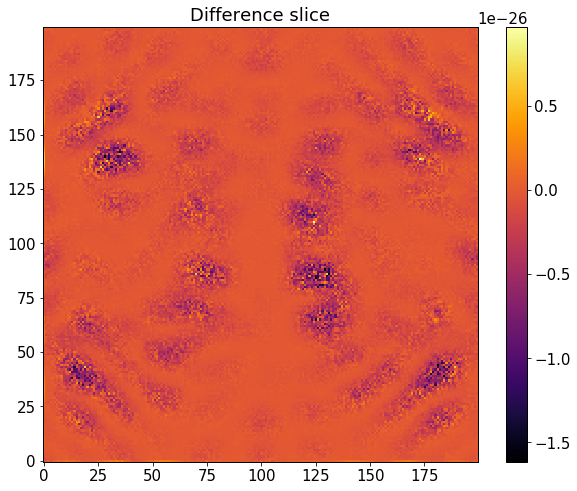

In [8]:
print newpsf.shape,l.shape
plt.figure(figsize=(10,8))
plt.imshow(newpsf[-1]-data_filtered[-1],cmap=cmap)
plt.title('Difference slice')
plt.colorbar()

In [9]:
fits.writeto('/Users/mrizzo/Downloads/interpolated.fits',newpsf,overwrite=True)
fits.writeto('/Users/mrizzo/Downloads/data_filtered.fits',data_filtered,overwrite=True)

## Turn into function

In [99]:
def interp(data,new_wavel):
    nl,nx,ny = data.shape
    x = np.arange(nx)
    y = np.arange(ny)
    new_wavel = np.linspace(0.7,0.84,25)
    l = (new_wavel-np.amin(new_wavel))*(nl-1)/(np.amax(new_wavel)-np.amin(new_wavel))
    l,x,y = np.meshgrid(l,x,y)
    newpsf = ndimage.map_coordinates(data,[l,x,y],prefilter=False,mode='nearest',order=1)
    return np.swapaxes(newpsf,0,1)

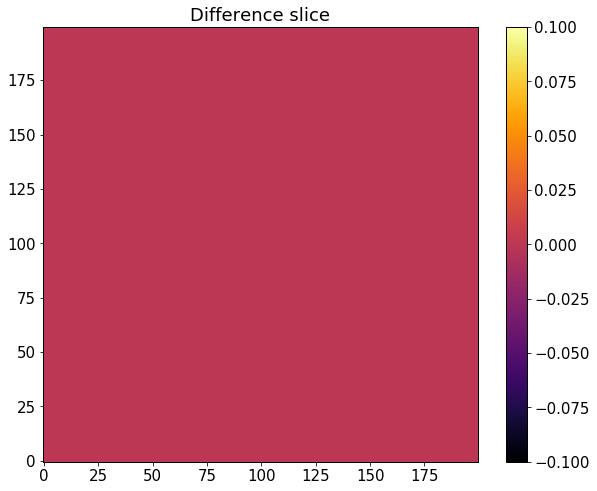

In [100]:
new = interp(psf_series,new_wavel)
plt.figure(figsize=(10,8))
plt.imshow(new[0]-psf_series[0],cmap=cmap)
plt.title('Difference slice')
plt.colorbar()
fits.writeto('/Users/mrizzo/Downloads/newinterp.fits',new,overwrite=True)
fits.writeto('/Users/mrizzo/Downloads/psf_series.fits',psf_series,overwrite=True)


# Flux normalization

In [10]:
import astropy.units as u
# erg s-1 cm-2 Ang-1
flam = u.erg/u.s/u.cm**2/u.Angstrom
fac = flam.to(u.W/u.m**2/u.nm)
print fac

0.01


## Load G0V star

Text(0,0.5,u'Flux (W.m$^{-2}$.nm$^{-1}$)')

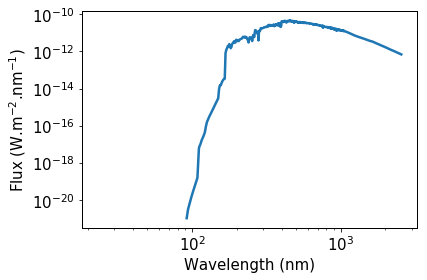

In [11]:
Vmag = 0
g0v_fits = fits.open('/Users/mrizzo/Downloads/grp 2/hst/cdbs/grid/bpgs/bpgs_35.fits')
g0v = np.array(g0v_fits[1].data)
dat = g0v['FLUX']*fac*10**(-0.4 * Vmag)
wav = g0v['WAVELENGTH']/10
plt.loglog(wav,dat)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Flux (W.m$^{-2}$.nm$^{-1}$)')


## Interpolate to the correct wavelengths

In [12]:
from scipy.interpolate import interp1d
wavel_hlc = np.arange(546.,604.)/1000.

func = interp1d(wav,dat,bounds_error=False,fill_value=0.0)
g0vflux = func(wavel_hlc*1000)*u.W/u.m**2/u.nm
print g0vflux

[  3.69624782e-11   3.64935374e-11   3.65044418e-11   3.62550719e-11
   3.66789342e-11   3.66571218e-11   3.67407285e-11   3.67879893e-11
   3.65807870e-11   3.65953240e-11   3.67843533e-11   3.59064584e-11
   3.56694431e-11   3.54371567e-11   3.44229402e-11   3.57810448e-11
   3.58610190e-11   3.52830265e-11   3.56414551e-11   3.56552669e-11
   3.52877554e-11   3.49227799e-11   3.52797548e-11   3.52234110e-11
   3.48951527e-11   3.46057905e-11   3.50914540e-11   3.53709978e-11
   3.56814439e-11   3.51928747e-11   3.47043054e-11   3.47982754e-11
   3.48922453e-11   3.51158096e-11   3.53393738e-11   3.55593003e-11
   3.57792268e-11   3.54955006e-11   3.52117745e-11   3.51236228e-11
   3.50354711e-11   3.44874684e-11   3.39394658e-11   3.34612581e-11
   3.29830503e-11   3.34986986e-11   3.40143469e-11   3.41659340e-11
   3.43175210e-11   3.42791715e-11   3.42408220e-11   3.39420107e-11
   3.36431993e-11   3.36539234e-11   3.36646475e-11   3.34928838e-11
   3.33211202e-11   3.34216335e-11

## Convert to correct units

[  1.01596091e+08   1.00490860e+08   1.00704655e+08   1.00199231e+08
   1.01555318e+08   1.01679461e+08   1.02096326e+08   1.02412851e+08
   1.02020180e+08   1.02244947e+08   1.02958259e+08   1.00681816e+08
   1.00196789e+08   9.97226823e+07   9.70418940e+07   1.01050660e+08
   1.01457047e+08   9.99994245e+07   1.01194709e+08   1.01413417e+08
   1.00545755e+08   9.96816323e+07   1.00878164e+08   1.00894374e+08
   1.00129774e+08   9.94736736e+07   1.01046359e+08   1.02029371e+08
   1.03104492e+08   1.01869896e+08   1.00630380e+08   1.01078039e+08
   1.01526644e+08   1.02353930e+08   1.03183467e+08   1.04004616e+08
   1.04827978e+08   1.04175390e+08   1.03519945e+08   1.03437602e+08
   1.03354372e+08   1.01911382e+08   1.00462875e+08   9.92157992e+07
   9.79639085e+07   9.96640867e+07   1.01369457e+08   1.01993211e+08
   1.02618492e+08   1.02676382e+08   1.02733886e+08   1.02008220e+08
   1.01279546e+08   1.01481248e+08   1.01683057e+08   1.01332858e+08
   1.00980928e+08   1.01453786e+08

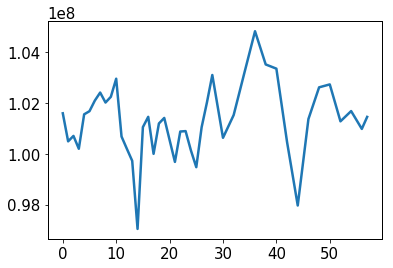

In [13]:
import astropy.constants as c
Eph = (c.c*c.h/(wavel_hlc*u.um)/u.photon).to(u.J/u.photon)
print (g0vflux/Eph).to(u.photon/u.s/u.m**2/u.nm)
plt.plot((g0vflux/Eph).to(u.photon/u.s/u.m**2/u.nm))

## Create function

In [14]:
from scipy.interpolate import interp1d
import astropy.constants as c
import astropy.units as u


def input_star(starfile,Vmag,wavel):
    '''
    Paramters
    ---------
    
    starfile: string
        Text file corresponding to the bpgs specturm in pysynphot catalog
    Vmag: float
        V magnitude of star
    wavel: array
        Array of desired wavelengths in microns
    '''
    fopen = fits.open(starfile)
    f = np.array(fopen[1].data)
    # erg s-1 cm-2 Ang-1
    flam = u.erg/u.s/u.cm**2/u.Angstrom
    fac = flam.to(u.W/u.m**2/u.nm)
    dat = f['FLUX']*fac*10**(-0.4 * Vmag)
    wav = f['WAVELENGTH']/10
    func = interp1d(wav,dat,bounds_error=False,fill_value=0.0)
    flux = func(wavel*1000)*u.W/u.m**2/u.nm
    Eph = (c.c*c.h/(wavel*u.um)/u.photon).to(u.J/u.photon)
    return (flux/Eph).to(u.photon/u.s/u.m**2/u.nm)


## Test conversion with HLC numbers in Vband

In [15]:
wavel_hlc = np.arange(546.,604.)/1000.
star = input_star('/Users/mrizzo/Downloads/grp 2/hst/cdbs/grid/bpgs/bpgs_7.fits',5,wavel_hlc)
startot = np.sum(star)*1*u.nm*3.6825*u.m**2*0.57*0.9*120*u.s
print '{:e}'.format(startot)
print 'Compare to 1.38e10 ph in John Krist OS6, {:.2f}% difference'.format(100*np.abs(startot-1.38e10*u.ph)/startot)

1.182743e+10 ph
Compare to 1.38e10 ph in John Krist OS6, 16.68% difference


## Load both target and reference stars

In [40]:
target_star_conv = input_star('/Users/mrizzo/Downloads/grp 2/hst/cdbs/grid/bpgs/bpgs_35.fits',5,new_wavel)*3.68*u.m**2
ref_star_conv = input_star('/Users/mrizzo/Downloads/grp 2/hst/cdbs/grid/bpgs/bpgs_7.fits',1.8,new_wavel)*3.68*u.m**2
dlam = new_wavel[1]-new_wavel[0]
dlam *= 1000*u.nm
print "Target total photons flux density: {:e}".format(np.sum(target_star_conv)*dlam)
print "Ref total photons flux density: {:e}".format(np.sum(ref_star_conv)*dlam)

Target total photons flux density: 4.636527e+08 ph / s
Ref total photons flux density: 4.498626e+09 ph / s


# Test IFS propagation with John Krist's files

In [51]:

from crispy.IFS import polychromeIFS
from crispy.tools.initLogger import getLogger
from crispy.tools.image import Image
log = getLogger('crispy')
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
fieldmask = fits.getdata(spc_psf_path+'field_mask.fits')
psf = Image(data=newpsf*ref_star_conv[:,np.newaxis,np.newaxis]*fieldmask[np.newaxis,:,:])
# psf = Image(data=newpsf*ref_star_conv[:,np.newaxis,np.newaxis])
psf.header['LAM_C'] = 0.77
psf.header['PIXSIZE'] = 0.1
wav = new_wavel

detector = polychromeIFS(par,wav*1000,psf,QE=True)
fits.writeto('/Users/mrizzo/Downloads/testIFS.fits',detector,overwrite=True)

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Writing data to ..//SimResults/detectorFramepoly.fits
crispy - INFO - Writing data to ..//SimResults/detectorFrame.fits
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total


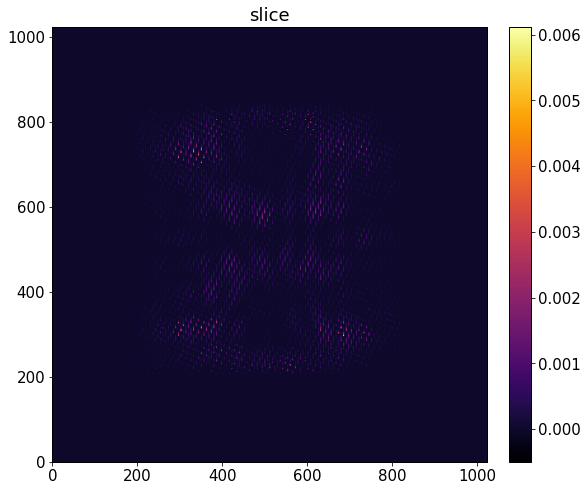

In [38]:
plt.figure(figsize=(10,8))
plt.imshow(detector.T,cmap=cmap)
plt.title('slice')
plt.colorbar(fraction=0.046, pad=0.04)

## Readout

In [70]:
detector = fits.getdata('/Users/mrizzo/Downloads/testIFS.fits')
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
detector[detector<0] = 0.0
obs = np.zeros_like(detector)
for i in range(1):
    if i%10==0: print i
    obsi = readoutWFIRST(detector.T,
                        tottime=120,
                        inttime=120,
                        PCcorrect=False, # don't correct for photon counting bias
                        PCmode = False,
                        crrate = 5.0,
                        EMGain = 5000.,
                        hprate=3.0,
                        lifefraction=0.0,
                        xs=2048,ys=1024,
                        QE = 1.0,
                        ).astype(np.int)
    for ix in range(1024):
        for iy in range(1024):
            if obsi[ix,iy]>65000:
                obsi[ix,iy:] = 0
                continue
#     mask = obsi>600
#     obsi[mask] = 1
#     obsi[~mask] = 0
    obs += obsi
fits.writeto('/Users/mrizzo/Downloads/obsIFS.fits',obs,overwrite=True)

0


In [63]:
from crispy.IFS import reduceIFSMap
from crispy.tools.image import Image

obsIFS = Image('/Users/mrizzo/Downloads/obsIFS.fits')
detector = reduceIFSMap(par,obsIFS.data.T,name='obsIFS',
                        method='optext',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=3
                       )

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/Downloads/obsIFS.fits
crispy - INFO - Mean, median, std: (1.2937820057429137, 1.0, 1.1674770422566385)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.830823s


# Apply to all files

## Propagate through IFS

In [105]:
psf_series_fname = spc_psf_path+'os6_spc_770nm_muf_images.fits'
fieldmask = fits.getdata(spc_psf_path+'field_mask.fits')

timesteps_fname = os.path.join(spc_psf_path+'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)
startype = timesteps[:,0]

convert_cube_ref = ref_star_conv[:,np.newaxis,np.newaxis]*fieldmask[np.newaxis,:,:]
convert_cube_target = target_star_conv[:,np.newaxis,np.newaxis]*fieldmask[np.newaxis,:,:]
par.saveDetector = False
par.savePoly = False
for i in range(53,3630):
    if i%100==0: print i
    openpsf = fits.open(psf_series_fname)[0].data[i]
    newpsf = interp(openpsf,new_wavel)
    if startype[i]==1: psf = Image(data=newpsf*convert_cube_ref)
    else: psf = Image(data=newpsf*convert_cube_target)
    psf.header['LAM_C'] = 0.77
    psf.header['PIXSIZE'] = 0.1
    detector = polychromeIFS(par,new_wavel*1000,psf,QE=True)
    fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % i,detector,overwrite=True)

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates


Traceback (most recent call last):
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
  

crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
700
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - IN

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
1100
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - I

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
2200
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
2600
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 21 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 21 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 21 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO -

crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 22 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total
crispy - INFO 

crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - 

crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 19 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO 

crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming sl

## Readout maps

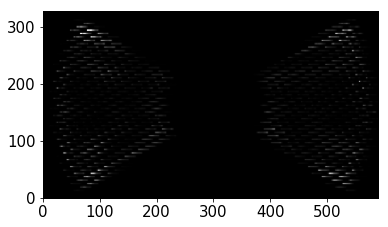

In [116]:
fname = '/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % 0
hdu = fits.open(fname)
o = hdu[0].data[350:680,225:815]
plt.imshow(o)

In [170]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST

timesteps_fname = os.path.join(spc_psf_path, 'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
roll = timesteps[:,3]

Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]

chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)
print "Number of chunks:",len(chunks_ind)

(3630, 4)
Number of chunks: 66


In [135]:
data_average=[]
for j in range(len(chunks_ind)):
    chunk_indiv_frame = []
    if j%(len(chunks_ind)//10)==0: print j,"/",len(chunks_ind)
    for i in range(len(chunks_ind[j])):
        ind = chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % ind
        hdu = fits.open(fname)
        o = hdu[0].data[350:680,225:815]
        o[o<0.0] = 0.0
        obs = readoutWFIRST(o.T,
                                tottime=120,
                                inttime=120,
                                PCcorrect=False, # don't correct for photon counting bias
                                PCmode = False,
                                crrate = 5.0,
                                hprate = 0.0,
                                lifefraction=0.5,
                                xs=1000,ys=600,
                                QE = 1.0,
                                ).astype(np.int)
        hdu.close()
        for ix in range(obs.shape[0]):
            for iy in range(obs.shape[1]):
                if obs[ix,iy]>65000:
                    obs[ix,iy:] = 0
                    continue

        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    data_average.append(np.nansum(np.array(chunk_indiv_frame),axis=0))
data_average = np.array(data_average)

(3630, 4)
Number of chunks: 66
0 / 66
6 / 66
12 / 66
18 / 66
24 / 66
30 / 66
36 / 66
42 / 66
48 / 66
54 / 66
60 / 66


In [136]:
fits.writeto('/Users/mrizzo/Downloads/spc_ifs_CR_PC_no_HP.fits',data_average, overwrite=True)


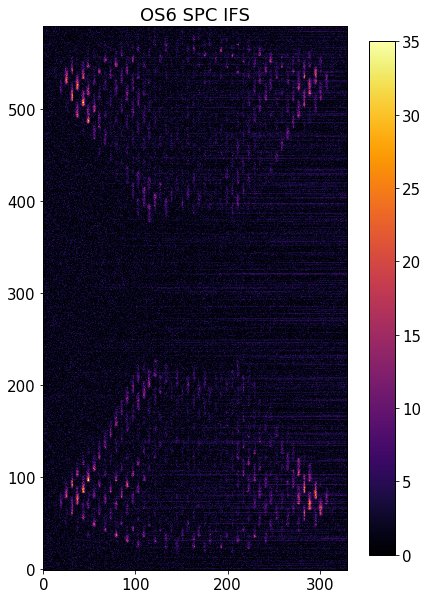

In [137]:
plt.figure(figsize=(10,10))
plt.title('OS6 SPC IFS')
plt.imshow(data_average[0],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


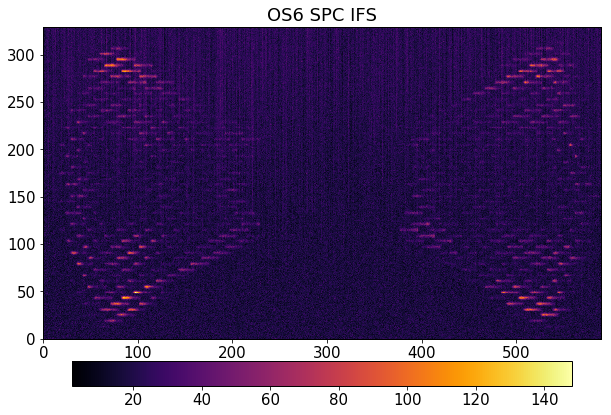

In [140]:
ave = np.zeros_like(data_average[0])
for i in range(len(data_average)):
    if startype[i]!=1: ave += data_average[i]
plt.figure(figsize=(10,10))
plt.title('OS6 SPC IFS')
plt.imshow(ave.T,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
fits.writeto('/Users/mrizzo/Downloads/spc_ifs_ave_CR_PC_no_HP.fits',ave, overwrite=True)


## Extract IFS map

In [145]:
IFSmap = np.zeros((1024,1024))
IFSmap[350:680,225:815] = ave.T-18

detector = reduceIFSMap(par,IFSmap,name='aveIFS',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=18,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )

crispy - INFO - Mean, median, std: (0.0, 0.0, 0.0)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Writing data to ..//SimResults/aveIFS_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/aveIFS_red_lstsq_conv_model.fits
crispy - INFO - Writing data to ..//SimResults/aveIFS_red_lstsq_conv_chisq.fits
crispy - INFO - Elapsed time: 37.393289s


# Add the planet

In [158]:
planetpsf_roll1 = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_3.41_-0.79.fits')
roll1 = interp(planetpsf_roll1,new_wavel)
fits.writeto('/Users/mrizzo/Downloads/planetpsf_roll1.fits',roll1,overwrite=True)
planetpsf_roll2 = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_3.41_0.79.fits')
roll2 = interp(planetpsf_roll2,new_wavel)
fits.writeto('/Users/mrizzo/Downloads/planetpsf_roll2.fits',roll2,overwrite=True)

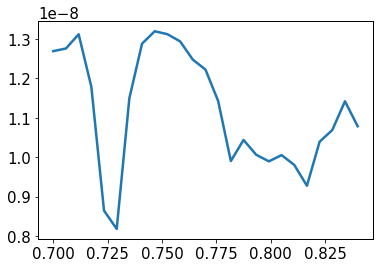

In [159]:
from crispy.tools.inputScene import calc_contrast

contrast = calc_contrast(new_wavel*1000,1.5,1,par.codeRoot +'/Inputs/Jupiter_1x_5AU_90deg.dat').value
plt.plot(new_wavel,contrast)

In [160]:
psf_roll1 = Image(data=roll1*convert_cube_target*contrast[:,np.newaxis,np.newaxis])
psf_roll1.header['LAM_C'] = 0.77
psf_roll1.header['PIXSIZE'] = 0.1
offaxis_roll1 = polychromeIFS(par,new_wavel*1000,psf_roll1,QE=True)
fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/offaxis_roll1.fits',offaxis_roll1,overwrite=True)
psf_roll2 = Image(data=roll2*convert_cube_target*contrast[:,np.newaxis,np.newaxis])
psf_roll2.header['LAM_C'] = 0.77
psf_roll2.header['PIXSIZE'] = 0.1
offaxis_roll2 = polychromeIFS(par,new_wavel*1000,psf_roll2,QE=True)
fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/offaxis_roll2.fits',offaxis_roll2,overwrite=True)

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total


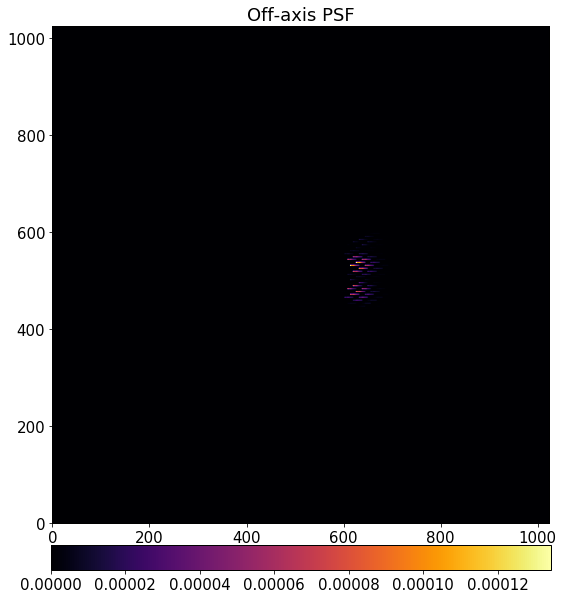

In [162]:
plt.figure(figsize=(10,10))
plt.title('Off-axis PSF')
plt.imshow(offaxis_roll2,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


# Re-run with planet

In [ ]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST

timesteps_fname = os.path.join(spc_psf_path, 'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
roll = timesteps[:,3]

Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]

chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)
print "Number of chunks:",len(chunks_ind)

data_average=[]
for j in range(len(chunks_ind)):
    chunk_indiv_frame = []
    if j%(len(chunks_ind)//10)==0: print j,"/",len(chunks_ind)
    for i in range(len(chunks_ind[j])):
        ind = chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % ind
        hdu = fits.open(fname)
        o = hdu[0].data#[350:680,225:815]
        if startype[ind]!=1: 
            if roll[ind]==1 or roll[ind]==3: o += offaxis_roll1#[350:680,225:815]
            else: o += offaxis_roll2#[350:680,225:815]
        o[o<0.0] = 0.0
        obs = readoutWFIRST(o.T,
                                tottime=120,
                                inttime=120,
                                PCcorrect=False, # don't correct for photon counting bias
                                PCmode = False,
                                crrate = 5.0,
                                hprate = 3.0,
                                lifefraction=0.5,
                                xs=1500,ys=1024,
                                QE = 1.0,
                                ).astype(np.int)
        hdu.close()
#         for ix in range(obs.shape[0]):
#             for iy in range(obs.shape[1]):
#                 if obs[ix,iy]>65000:
#                     obs[ix,iy:] = 0
#                     continue

#         mask = obs>600
#         obs[mask] = 1
#         obs[~mask] = 0
        fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind,obs,overwrite=True)
        chunk_indiv_frame.append(obs)
    data_average.append(np.nansum(np.array(chunk_indiv_frame),axis=0))
data_average = np.array(data_average)



(3630, 4)
Number of chunks: 66
0 / 66
6 / 66
12 / 66


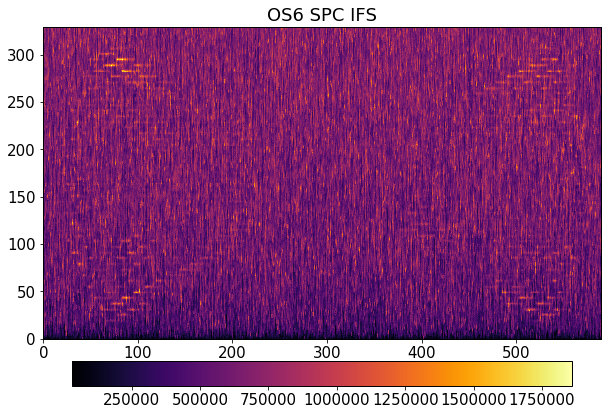

In [173]:
ave = np.zeros_like(data_average[0])
for i in range(len(data_average)):
    if startype[i]!=1: ave += data_average[i]
plt.figure(figsize=(10,10))
plt.title('OS6 SPC IFS')
plt.imshow(ave.T,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


## Process files

In [176]:
timesteps_fname = os.path.join(spc_psf_path, 'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
roll = timesteps[:,3]


Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)



for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])



print 'Summary:'
print 'There are %d reference chunks' % len(reference_chunks_ind)
print 'There are %d target chunks with minus 13deg roll' % len(roll_minus_chunks_ind)
print 'There are %d target chunks with plus 13deg roll' % len(roll_plus_chunks_ind)


from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
        for ix in range(obs.shape[0]):
            for iy in range(obs.shape[1]):
                if obs[ix,iy]>65000:
                    obs[ix,iy:] = 0
                    continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    reference_data_average.append(np.nansum(chunk_indiv_frame,axis=0))

roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
        for ix in range(obs.shape[0]):
            for iy in range(obs.shape[1]):
                if obs[ix,iy]>65000:
                    obs[ix,iy:] = 0
                    continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    roll_minus_data_average.append(np.nansum(chunk_indiv_frame,axis=0))

roll_plus_data_average = []
for j in range(len(roll_plus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_plus_chunks_ind[j])):
        ind = roll_plus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
        for ix in range(obs.shape[0]):
            for iy in range(obs.shape[1]):
                if obs[ix,iy]>65000:
                    obs[ix,iy:] = 0
                    continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    roll_plus_data_average.append(np.nansum(chunk_indiv_frame,axis=0))


fits.writeto('/Users/mrizzo/IFS/OS6/references_haystacks_spc.fits',np.array(reference_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_minus_haystacks_spc.fits',np.array(roll_minus_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_plus_haystacks_spc.fits',np.array(roll_plus_data_average), overwrite=True)

(3630, 4)
Summary:
There are 14 reference chunks
There are 26 target chunks with minus 13deg roll
There are 26 target chunks with plus 13deg roll


In [177]:
fits.writeto('/Users/mrizzo/IFS/OS6/roll_minus_haystacks_spc_ave.fits',np.mean(np.array(roll_minus_data_average),axis=0), overwrite=True)
